In [10]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
!conda install -c conda-forge folium

import os
import folium # map rendering library
# Matplotlib and associated plotting modules

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mp
import re
import csv
%matplotlib inline


print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Libraries imported.


In [11]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    locatidn = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [12]:
def get_venues(lat,lng):
    
    #set variables
    radius=10000
    LIMIT=100
    CLIENT_ID = 'TX4JUKX35YEO31T2BIG1VLJR45TU2JALKQVOUPNN0MTXGFVL' # Foursquare ID
    CLIENT_SECRET = 'PPA231QLC0NTLDLN3MZR0X54C4QH5JO5DKOBO4BJGLQYB1SJ' #  Foursquare Secret
    VERSION = '20200227'  #version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [13]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'TX4JUKX35YEO31T2BIG1VLJR45TU2JALKQVOUPNN0MTXGFVL' # Foursquare ID
    CLIENT_SECRET = 'PPA231QLC0NTLDLN3MZR0X54C4QH5JO5DKOBO4BJGLQYB1SJ' #  Foursquare Secret
    VERSION = '20200227'  #version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [14]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [15]:
new_york_data=get_new_york_data()
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [16]:

new_york_data.shape

(306, 4)

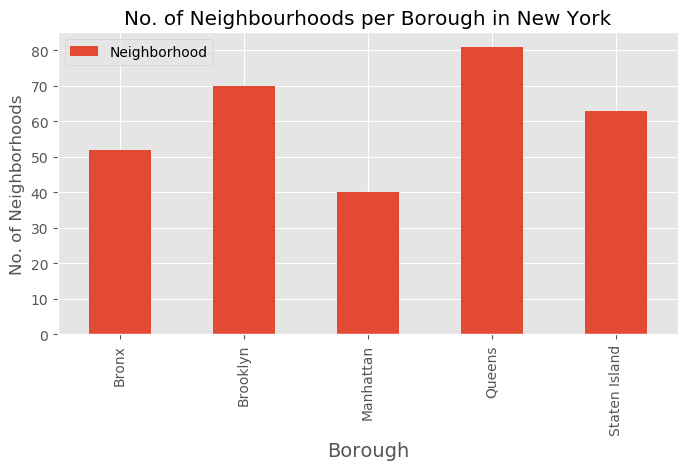

In [72]:

from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(8,4), dpi = 100)
# title
plt.title('No. of Neighbourhoods per Borough in New York')
#On x-axis
plt.xlabel('Borough Name', fontsize = 14)
#On y-axis
plt.ylabel('No. of Neighborhoods', fontsize=12)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
plt.show()

In [18]:

# prepare neighborhood list that contains asian restaurant
column_names=['Borough', 'Neighborhood', 'ID','Name']
asian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    asian_resturants=venues[venues['Category']=='Asian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Asian Resturants in '+Neighborhood+', '+Borough+':'+str(len('asian_resturants')))
    for resturant_detail in asian_resturants.values.tolist():
        id, name , category=resturant_detail
        asian_rest_ny = asian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Asian Resturants in Wakefield, Bronx:16
( 2 / 306 ) Asian Resturants in Co-op City, Bronx:16
( 3 / 306 ) Asian Resturants in Eastchester, Bronx:16
( 4 / 306 ) Asian Resturants in Fieldston, Bronx:16
( 5 / 306 ) Asian Resturants in Riverdale, Bronx:16
( 6 / 306 ) Asian Resturants in Kingsbridge, Bronx:16
( 7 / 306 ) Asian Resturants in Marble Hill, Manhattan:16
( 8 / 306 ) Asian Resturants in Woodlawn, Bronx:16
( 9 / 306 ) Asian Resturants in Norwood, Bronx:16
( 10 / 306 ) Asian Resturants in Williamsbridge, Bronx:16
( 11 / 306 ) Asian Resturants in Baychester, Bronx:16
( 12 / 306 ) Asian Resturants in Pelham Parkway, Bronx:16
( 13 / 306 ) Asian Resturants in City Island, Bronx:16
( 14 / 306 ) Asian Resturants in Bedford Park, Bronx:16
( 15 / 306 ) Asian Resturants in University Heights, Bronx:16
( 16 / 306 ) Asian Resturants in Morris Heights, Bronx:16
( 17 / 306 ) Asian Resturants in Fordham, Bronx:16
( 18 / 306 ) Asian Resturants in East Tremont, Bronx:16
( 19 / 306 ) Asi

( 143 / 306 ) Asian Resturants in Maspeth, Queens:16
( 144 / 306 ) Asian Resturants in Ridgewood, Queens:16
( 145 / 306 ) Asian Resturants in Glendale, Queens:16
( 146 / 306 ) Asian Resturants in Rego Park, Queens:16
( 147 / 306 ) Asian Resturants in Woodhaven, Queens:16
( 148 / 306 ) Asian Resturants in Ozone Park, Queens:16
( 149 / 306 ) Asian Resturants in South Ozone Park, Queens:16
( 150 / 306 ) Asian Resturants in College Point, Queens:16
( 151 / 306 ) Asian Resturants in Whitestone, Queens:16
( 152 / 306 ) Asian Resturants in Bayside, Queens:16
( 153 / 306 ) Asian Resturants in Auburndale, Queens:16
( 154 / 306 ) Asian Resturants in Little Neck, Queens:16
( 155 / 306 ) Asian Resturants in Douglaston, Queens:16
( 156 / 306 ) Asian Resturants in Glen Oaks, Queens:16
( 157 / 306 ) Asian Resturants in Bellerose, Queens:16
( 158 / 306 ) Asian Resturants in Kew Gardens Hills, Queens:16
( 159 / 306 ) Asian Resturants in Fresh Meadows, Queens:16
( 160 / 306 ) Asian Resturants in Briarwo

( 280 / 306 ) Asian Resturants in Fulton Ferry, Brooklyn:16
( 281 / 306 ) Asian Resturants in Vinegar Hill, Brooklyn:16
( 282 / 306 ) Asian Resturants in Weeksville, Brooklyn:16
( 283 / 306 ) Asian Resturants in Broadway Junction, Brooklyn:16
( 284 / 306 ) Asian Resturants in Dumbo, Brooklyn:16
( 285 / 306 ) Asian Resturants in Manor Heights, Staten Island:16
( 286 / 306 ) Asian Resturants in Willowbrook, Staten Island:16
( 287 / 306 ) Asian Resturants in Sandy Ground, Staten Island:16
( 288 / 306 ) Asian Resturants in Egbertville, Staten Island:16
( 289 / 306 ) Asian Resturants in Roxbury, Queens:16
( 290 / 306 ) Asian Resturants in Homecrest, Brooklyn:16
( 291 / 306 ) Asian Resturants in Middle Village, Queens:16
( 292 / 306 ) Asian Resturants in Prince's Bay, Staten Island:16
( 293 / 306 ) Asian Resturants in Lighthouse Hill, Staten Island:16
( 294 / 306 ) Asian Resturants in Richmond Valley, Staten Island:16
( 295 / 306 ) Asian Resturants in Malba, Queens:16
( 296 / 306 ) Asian Res

In [76]:

asian_rest_ny.head

<bound method NDFrame.head of      Borough       Neighborhood                        ID               Name
0   Brooklyn        Bensonhurst  4b280f8cf964a520698e24e3       Cafe Kashkar
1   Brooklyn          Gravesend  4b280f8cf964a520698e24e3       Cafe Kashkar
2   Brooklyn     Brighton Beach  4b280f8cf964a520698e24e3       Cafe Kashkar
3   Brooklyn     Sheepshead Bay  4b280f8cf964a520698e24e3       Cafe Kashkar
4   Brooklyn  Manhattan Terrace  4b280f8cf964a520698e24e3       Cafe Kashkar
5   Brooklyn      Starrett City  545ecd4b498eefe9c0237723          Little Mo
6   Brooklyn        Mill Island  4b280f8cf964a520698e24e3       Cafe Kashkar
7   Brooklyn    Manhattan Beach  4b280f8cf964a520698e24e3       Cafe Kashkar
8   Brooklyn       Coney Island  4b280f8cf964a520698e24e3       Cafe Kashkar
9   Brooklyn         Bath Beach  4b280f8cf964a520698e24e3       Cafe Kashkar
10  Brooklyn      Dyker Heights  4b280f8cf964a520698e24e3       Cafe Kashkar
11  Brooklyn    Gerritsen Beach  4b280f8cf964a

In [20]:
asian_rest_ny.shape

(27, 4)

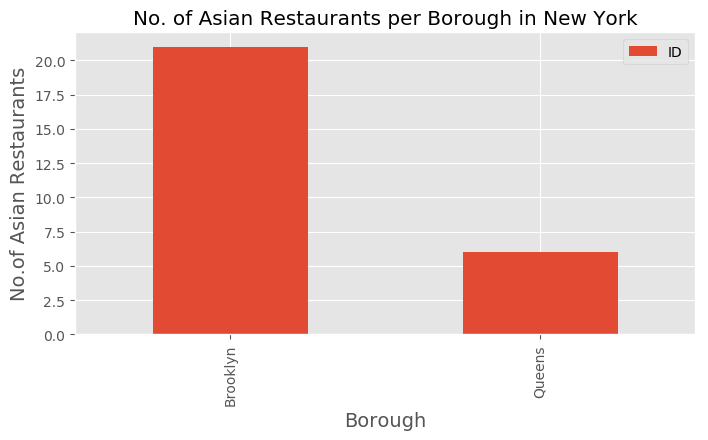

In [75]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(8,4), dpi = 100)
# title
plt.title('No. of Asian Restaurants per Borough in New York')
#On x-axis
plt.xlabel('Borough', fontsize = 14)
#On y-axis
plt.ylabel('No.of Asian Restaurants', fontsize=14)
#giving a bar plot
asian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [22]:

asian_rest_ny[asian_rest_ny['Borough']=='Brooklyn']

,Borough,Neighborhood,ID,Name
0,Brooklyn,Bensonhurst,4b280f8cf964a520698e24e3,Cafe Kashkar
1,Brooklyn,Gravesend,4b280f8cf964a520698e24e3,Cafe Kashkar
2,Brooklyn,Brighton Beach,4b280f8cf964a520698e24e3,Cafe Kashkar
3,Brooklyn,Sheepshead Bay,4b280f8cf964a520698e24e3,Cafe Kashkar
4,Brooklyn,Manhattan Terrace,4b280f8cf964a520698e24e3,Cafe Kashkar
5,Brooklyn,Starrett City,545ecd4b498eefe9c0237723,Little Mo
6,Brooklyn,Mill Island,4b280f8cf964a520698e24e3,Cafe Kashkar
7,Brooklyn,Manhattan Beach,4b280f8cf964a520698e24e3,Cafe Kashkar
8,Brooklyn,Coney Island,4b280f8cf964a520698e24e3,Cafe Kashkar
9,Brooklyn,Bath Beach,4b280f8cf964a520698e24e3,Cafe Kashkar


In [23]:
asian_rest_ny[asian_rest_ny['Borough']=='Queens']

,Borough,Neighborhood,ID,Name
17,Queens,Cambria Heights,5755f1c1498e9a9df723897b,Nova Asian Bistro
18,Queens,Breezy Point,4b280f8cf964a520698e24e3,Cafe Kashkar
19,Queens,Neponsit,4b280f8cf964a520698e24e3,Cafe Kashkar
20,Queens,Lindenwood,545ecd4b498eefe9c0237723,Little Mo
21,Queens,Belle Harbor,4b280f8cf964a520698e24e3,Cafe Kashkar
24,Queens,Roxbury,4b280f8cf964a520698e24e3,Cafe Kashkar


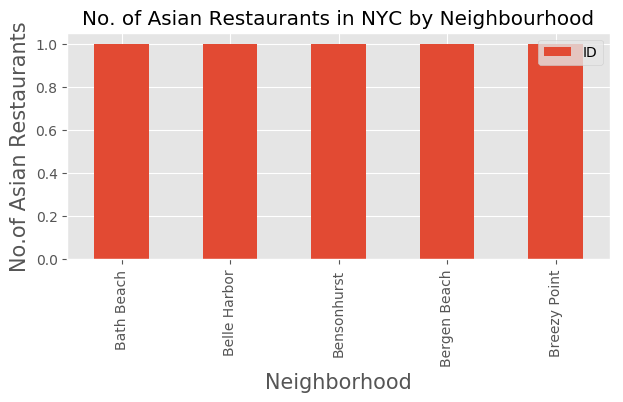

In [81]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(7,3), dpi = 100)
# title
plt.title('No. of Asian Restaurants in NYC by Neighbourhood')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Asian Restaurants', fontsize=15)
#giving a bar plot
asian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [28]:

column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
asian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in asian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row

    # prepare neighborhood list that contains Asian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
asian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in asian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except (IndexError, KeyError) as e:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(asian_rest_ny),')','processed')
    asian_rest_stats_ny = asian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID          Name  Likes  Rating  Tips
0  4b280f8cf964a520698e24e3  Cafe Kashkar    110     8.8    40
( 1 / 27 ) processed
                         ID          Name  Likes  Rating  Tips
0  4b280f8cf964a520698e24e3  Cafe Kashkar    110     8.8    40
( 2 / 27 ) processed
                         ID          Name  Likes  Rating  Tips
0  4b280f8cf964a520698e24e3  Cafe Kashkar    110     8.8    40
( 3 / 27 ) processed
                         ID          Name  Likes  Rating  Tips
0  4b280f8cf964a520698e24e3  Cafe Kashkar    110     8.8    40
( 4 / 27 ) processed
                         ID          Name  Likes  Rating  Tips
0  4b280f8cf964a520698e24e3  Cafe Kashkar    110     8.8    40
( 5 / 27 ) processed
                         ID       Name  Likes  Rating  Tips
0  545ecd4b498eefe9c0237723  Little Mo    215     8.9    40
( 6 / 27 ) processed
                         ID          Name  Likes  Rating  Tips
0  4b280f8cf964a520698e24e3  Cafe Kashkar    110     8.8    4

In [29]:
asian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Brooklyn,Bensonhurst,4b280f8cf964a520698e24e3,Cafe Kashkar,110,8.8,40
1,Brooklyn,Gravesend,4b280f8cf964a520698e24e3,Cafe Kashkar,110,8.8,40
2,Brooklyn,Brighton Beach,4b280f8cf964a520698e24e3,Cafe Kashkar,110,8.8,40
3,Brooklyn,Sheepshead Bay,4b280f8cf964a520698e24e3,Cafe Kashkar,110,8.8,40
4,Brooklyn,Manhattan Terrace,4b280f8cf964a520698e24e3,Cafe Kashkar,110,8.8,40


In [30]:
asian_rest_stats_ny.shape

(27, 7)

In [31]:
asian_rest_stats_ny['Likes']=asian_rest_stats_ny['Likes'].astype('float64')

In [32]:

asian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 7 columns):
Borough         27 non-null object
Neighborhood    27 non-null object
ID              27 non-null object
Name            27 non-null object
Likes           27 non-null float64
Rating          27 non-null float64
Tips            27 non-null object
dtypes: float64(2), object(5)
memory usage: 1.6+ KB


In [33]:

ny_neighborhood_stats=asian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [34]:

ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
13,Lindenwood,8.9
22,Paerdegat Basin,8.9
26,Starrett City,8.9
3,Bergen Beach,8.8
4,Breezy Point,8.8
25,Sheepshead Bay,8.8
24,Sea Gate,8.8
23,Roxbury,8.8
2,Bensonhurst,8.8
21,Ocean Parkway,8.8


In [36]:
ny_borough_stats=asian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [96]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
0,Brooklyn,8.809524
1,Queens,8.716667


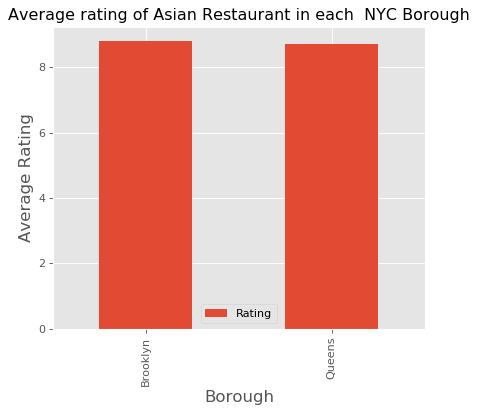

In [85]:

plt.figure(figsize=(6,5), dpi = 80)
# title
plt.title('Average rating of Asian Restaurant in each  NYC Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
asian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [97]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]

In [98]:
ny_neighborhood_stats

,Borough_x,Neighborhood,Latitude_x,Longitude_x,Average Rating,Label,Borough_y,Latitude_y,Longitude_y,Borough,Latitude,Longitude
0,Brooklyn,Bath Beach,40.599519,-73.998752,8.8,"Bath Beach, Brooklyn(8.8)",Brooklyn,40.599519,-73.998752,Brooklyn,40.599519,-73.998752
1,Queens,Belle Harbor,40.576156,-73.854018,8.8,"Belle Harbor, Queens(8.8)",Queens,40.576156,-73.854018,Queens,40.576156,-73.854018
2,Brooklyn,Bensonhurst,40.611009,-73.995180,8.8,"Bensonhurst, Brooklyn(8.8)",Brooklyn,40.611009,-73.995180,Brooklyn,40.611009,-73.995180
3,Brooklyn,Bergen Beach,40.615150,-73.898556,8.8,"Bergen Beach, Brooklyn(8.8)",Brooklyn,40.615150,-73.898556,Brooklyn,40.615150,-73.898556
4,Queens,Breezy Point,40.557401,-73.925512,8.8,"Breezy Point, Queens(8.8)",Queens,40.557401,-73.925512,Queens,40.557401,-73.925512
5,Brooklyn,Brighton Beach,40.576825,-73.965094,8.8,"Brighton Beach, Brooklyn(8.8)",Brooklyn,40.576825,-73.965094,Brooklyn,40.576825,-73.965094
6,Brooklyn,Coney Island,40.574293,-73.988683,8.8,"Coney Island, Brooklyn(8.8)",Brooklyn,40.574293,-73.988683,Brooklyn,40.574293,-73.988683
7,Brooklyn,Dyker Heights,40.619219,-74.019314,8.8,"Dyker Heights, Brooklyn(8.8)",Brooklyn,40.619219,-74.019314,Brooklyn,40.619219,-74.019314
8,Brooklyn,Georgetown,40.623845,-73.916075,8.8,"Georgetown, Brooklyn(8.8)",Brooklyn,40.623845,-73.916075,Brooklyn,40.623845,-73.916075
9,Brooklyn,Gerritsen Beach,40.590848,-73.930102,8.8,"Gerritsen Beach, Brooklyn(8.8)",Brooklyn,40.590848,-73.930102,Brooklyn,40.590848,-73.930102


In [93]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [99]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [100]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Borough,Neighborhood,Latitude,Longitude,Average Rating
25,Brooklyn,Starrett City,40.647589,-73.879370,8.9
21,Brooklyn,Paerdegat Basin,40.631318,-73.902335,8.9
12,Queens,Lindenwood,40.663918,-73.849638,8.9
14,Brooklyn,Manhattan Beach,40.577914,-73.943537,8.8
24,Brooklyn,Sheepshead Bay,40.586890,-73.943186,8.8
23,Brooklyn,Sea Gate,40.576375,-74.007873,8.8
22,Queens,Roxbury,40.567376,-73.892138,8.8
20,Brooklyn,Ocean Parkway,40.613060,-73.968367,8.8
19,Queens,Neponsit,40.572037,-73.857547,8.8
18,Brooklyn,Mill Island,40.606336,-73.908186,8.8


In [59]:
ny_map = folium.Map(location=(40.7128, -74.0060), zoom_start=12)

In [66]:

# instantiate a feature group for the restaurants in the dataframe
restaurants = folium.map.FeatureGroup()

# loop through the 100 restaurants and add each to the group:
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    restaurants.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=8, # define how big you want the circle markers to be
            color='green',
            fill=True,
            fill_color='red',
            fill_opacity=0.5
        )
    )

In [67]:

ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [68]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(restaurants)